# Tutorial

A lot of effort has been put into building climate models in order to understand Earth's atmosphere and project future climate trends.  In the last two decades, an important area of focus has been the possible role of the sun in climate trends.  It has been shown that cloud seeding by cosmic rays is a real mechanism, but this idea has not yet been fully characterized and modeled.  In this tutorial, we will introduce the cloud seeding model and explore how a cloud seeding mechanism can modify a traditional greenhouse gas (GHG) based climate model.

## Imports

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The next set of imports is from our package:

In [2]:
# modules for climate model analysis
from climate import data_io
from climate import model

## Example data

The data against which we compare our model is a timeseries of global temperature 'anomaly' averages.  In climate physics, temperature 'anomaly' refers to a departure from the long-term average.

In [5]:
# read in temperature data and uncertainties
fileload = data_io.get_example_data_file_path(
    'global_surface_temp_seaice_air_infer.txt')
data = data_io.load_data_temp(fileload)
x, y, yerr = data['year'], data['monthly_anomaly'], data['monthly_anomaly_unc']

# the temperature data are recorded at monthly intervals, but we will 
# downsample to match the (yearly) resolution of the emissions files
x = x.values[0::12]
y = y.values[0::12]
yerr = yerr.values[0::12]

Now we will plot the temperature anomaly and errorbars:

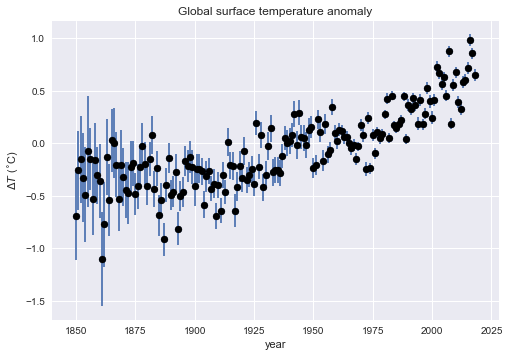

In [14]:
# we can plot temperature anomaly vs. time
plt.errorbar(x, y, yerr, fmt="o")
plt.scatter(x, y, c='k', zorder=5)
plt.xlabel('year')
plt.ylabel('$\Delta T$ ($^{\circ}$C)')
plt.title('Global surface temperature anomaly');

As a starting point for doing Bayesian inference, parameter estimation, and eventually model comparison, we can consider a traditional climate model that computes heating via the greenhouse gas effect.  This requires some timeseries data for the atmospheric emissions of GHG.  To compute temperature anomaly due to GHG, we employ the pythonpackage <code>pySCM</code>, or "Simple Climate Model."  The GHG considered in this model are carbon dioxide (CO$_2$), methane (CH$_4$), nitrous oxide (N$_{2}$O) and sulfate (SOx).  For our purposes, we will generalize the model by considereing the emissions curves as varying by normalization factors $\alpha_1, \alpha_2, \alpha_3, \alpha_4,$ and also introduce a parameter to allow for an overall temperature shift (this is probably not a physical parameter, but just a mathematical device to allow for fitting to the temperature anomaly data, since the departure from 'long term behavior' is not entirely clear).  In effect, our generalized traditional climate model has 5 parameters; 1 overall constant temperature shift (not physical), and 4 normalizations to the GHG atmospheric emissions (yes physical).

We will make some initial guess for the normalizations as 1, assuming that the emissions data produce a temperature anomaly curve that is similar to the actual data.  Based on the plot of temperature anomaly above, we will guess the shift as -0.4.  We will use a sampling method (affine-invariant ensemble average) to sample the posterior distribution.  We will assume a uniform prior on our shift parameter, as well as the normalizations.

We take as our log-likelihood:
$$\log(P(D|\theta, M))=\sum \frac{1}{\sqrt{2 \pi \sigma_{y}^2}}
- 0.5 \sum (\frac{y_{\rm D}-y_{\rm tcm}}{\sigma_{y}})^2,$$
where subscripts 'D' and 'tcm' refer to 'data' and 'traditional climate model', respectively.  With uniform priors, the log-posterior distribution is then
$$\log(P(\theta|D, M)) \propto \log(P(D|\theta, M)) + \log(P(\theta|M))$$

We'll compute this below and output some best fit values for normalizations, shift, and some error intervals:

shift = -0.349285 + 0.025862 - 0.029956
CO2_norm = 1.101189 + 0.115967 - 0.182003
CH4_norm = 1.038129 + 0.211172 - 0.162148
N2O_norm = 1.289929 + 0.008294 - 0.017997
SOx_norm = 0.889450 + 0.092405 - 0.137112
CPU times: user 13min 6s, sys: 18.8 s, total: 13min 24s
Wall time: 13min 27s


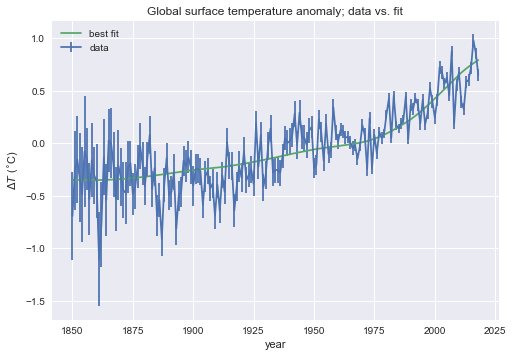

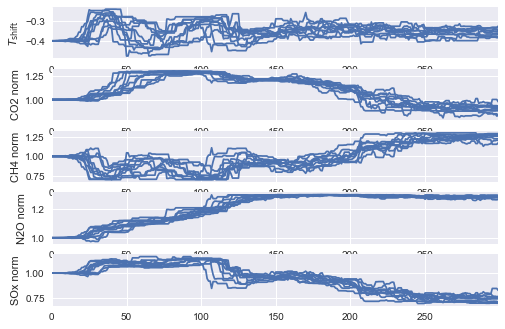

In [4]:
# Sample the distribution, output best fit parameters, and plot
%time model.sample(model.log_post_tcm, x, y, yerr, [-0.4, 1., 1., 1., 1.],ndim=5, nwalkers=10, nsteps=300, burnin=100)

This was a very coarse sampling of the distribution, because the model takes ~0.35 seconds for each run, so we might consider some parallel processing in the future.  We also probably need to play around with the priors for our normalizations to get a more adequate fit.